In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1.	Data Organization

In [ ]:
import sys
import os
import pandas as pd   # data analysis
import numpy as np    # numerical analysis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.anova import anova_lm
from sklearn.impute import SimpleImputer
# --- Install ISLP if missing ---
try:
    import ISLP
except ImportError:
    !pip install ISLP
    import ISLP

from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly
# --- Google Colab setup ---
from google.colab import drive
drive.mount('/content/drive')

# Show all columns & rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option("display.max_info_columns", 999)

dir = '/content/drive/MyDrive/Colab Notebooks/BUS 310/Data'
print("Files in data directory:", os.listdir(dir))
data_path = os.path.join(dir, 'housing_price_full_sample.csv')
df_raw = pd.read_csv(data_path)  # keep raw for EDA
df = df_raw.copy()               # working df for regression

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=ac3246965baf4c177d1e48710aa01357730786688a404585796a59bd6ea433ac
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in data directory: ['Advertising.csv', '

In [ ]:
# Check if plt.show has already been patched to avoid recursion
if 'original_show' not in plt.__dict__:
    plt.close('all')
    drive.mount('/content/drive')
    save_dir = '/content/drive/MyDrive/Colab Notebooks/BUS 310/Group Assignment'
    os.makedirs(save_dir, exist_ok=True)

    # Store the original show function in a way that won't be overwritten
    plt.original_show = plt.show
    counter = 1
    saved_figures = set()

    def auto_save_show(*args, **kwargs):
        global counter, saved_figures

        if plt.get_fignums():
            fig_id = id(plt.gcf())

            if fig_id not in saved_figures:
                try:
                    fig = plt.gcf()
                    title = fig._suptitle.get_text() if fig._suptitle else plt.gca().get_title()

                    if title:
                        filename = title.replace(' ', '_').replace('/', '_')
                    else:
                        filename = f"plot_{counter}"

                    plt.savefig(f'{save_dir}/{filename}.png', dpi=300, bbox_inches='tight')
                    print(f"Saved: {filename}.png")
                    saved_figures.add(fig_id)
                    counter += 1

                except Exception as e:
                    print(f"Error saving plot: {e}")

        # Call the original show function that was safely stored
        return plt.original_show(*args, **kwargs)

    # Apply the patch
    plt.show = auto_save_show
    print("plt.show has been patched for auto-saving.")
else:
    print("plt.show was already patched. Skipping re-patching.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
plt.show has been patched for auto-saving.


###1.1. Missing data

In [ ]:
missing = df.isna().sum()
missing = missing[missing > 0]
print(missing.sort_values(ascending=False))

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageCond       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
Functional         2
BsmtHalfBath       2
Utilities          2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
KitchenQual        1
GarageArea         1
GarageCars         1
SaleType           1
dtype: int64


In [ ]:
# Numeric imputation
num_cols = df.select_dtypes(include=["float64","int64"]).columns
num_imputer = SimpleImputer(strategy="mean")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Categorical imputation
cat_cols = df.select_dtypes(include=["object"]).columns
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

###1.2. Label encoding/factorizing the remaining character variables

In [ ]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,

###1.3 Changing some numeric variables into categorical variables

In [ ]:
#Changing numeric variables to categorical
print("Years in dataset:", df['YrSold'].nunique())
print("Year range:", df['YrSold'].min(), "-", df['YrSold'].max())

# Convert these variables to categorical and create dummies
categorical_vars = ['YrSold', 'MoSold', 'YearBuilt', 'MSSubClass']
df[categorical_vars] = df[categorical_vars].astype('object')

# Now update dfcopy with these changes
df = pd.get_dummies(df, columns=['YrSold','MoSold','YearBuilt','MSSubClass'], drop_first=True)

Years in dataset: 5
Year range: 2006.0 - 2010.0


##2. Exploratory Data Analysis

###2.1.	Exploring the dataset

In [ ]:
df.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,YrSold_2007.0,YrSold_2008.0,YrSold_2009.0,YrSold_2010.0,MoSold_2.0,MoSold_3.0,MoSold_4.0,MoSold_5.0,MoSold_6.0,MoSold_7.0,MoSold_8.0,MoSold_9.0,MoSold_10.0,MoSold_11.0,MoSold_12.0,YearBuilt_187

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 389 columns):
 #    Column                 Non-Null Count  Dtype  
---   ------                 --------------  -----  
 0    Id                     2919 non-null   float64
 1    LotFrontage            2919 non-null   float64
 2    LotArea                2919 non-null   float64
 3    OverallQual            2919 non-null   float64
 4    OverallCond            2919 non-null   float64
 5    YearRemodAdd           2919 non-null   float64
 6    MasVnrArea             2919 non-null   float64
 7    BsmtFinSF1             2919 non-null   float64
 8    BsmtFinSF2             2919 non-null   float64
 9    BsmtUnfSF              2919 non-null   float64
 10   TotalBsmtSF            2919 non-null   float64
 11   1stFlrSF               2919 non-null   float64
 12   2ndFlrSF               2919 non-null   float64
 13   LowQualFinSF           2919 non-null   float64
 14   GrLivArea              2919 non-null  

###2.2. Exploring important variables

####Output Variable: SalePrice

In [ ]:
print(df["SalePrice"].describe().round(2))

count      2919.00
mean     180052.86
std       57381.56
min       34900.00
25%      154795.00
50%      176735.00
75%      191896.00
max      755000.00
Name: SalePrice, dtype: float64


Saved: Boxplot_of_SalePrice.png


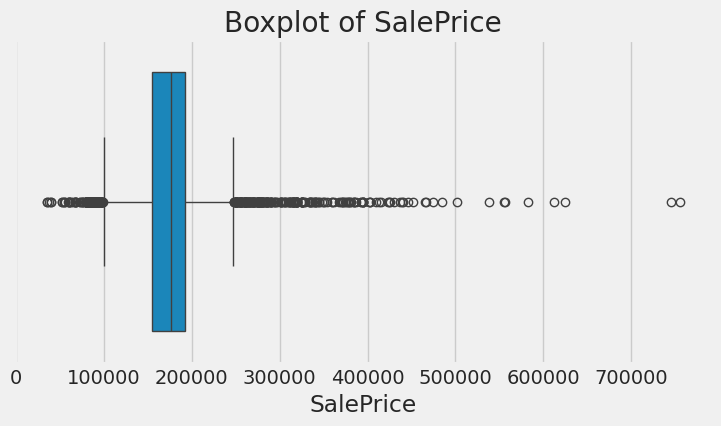

In [ ]:
# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["SalePrice"])
plt.title("Boxplot of SalePrice")
plt.show()

Saved: SalePrice_Distribution.png


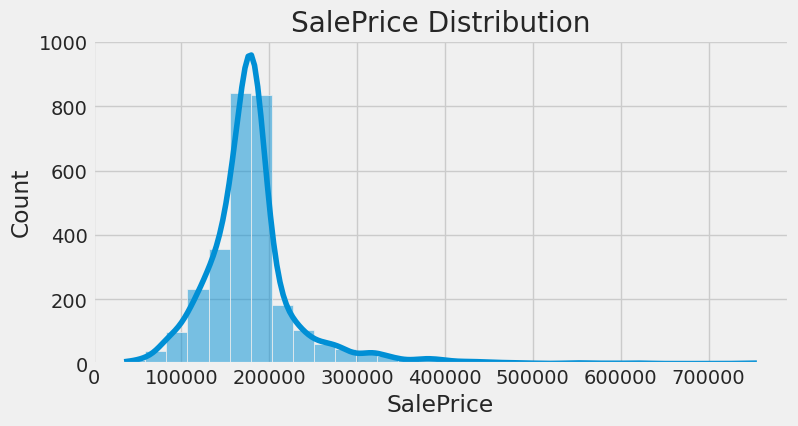

In [ ]:
# Histogram + KDE
plt.figure(figsize=(8, 4))
sns.histplot(df["SalePrice"], kde=True, bins=30)
plt.title("SalePrice Distribution")
plt.show()

####Important numerical predictors

In [ ]:
num_vars = df.select_dtypes(include=["float64","int64"]).columns
print("Number of numerical variables:", len(num_vars))

Number of numerical variables: 34


In [ ]:
# Correlations
corrs = df[num_vars].corr()["SalePrice"].sort_values(ascending=False)
print("Top correlations with SalePrice:\n", corrs.head(15))

Top correlations with SalePrice:
 SalePrice       1.000000
GrLivArea       0.588010
OverallQual     0.550911
TotRmsAbvGrd    0.469800
GarageCars      0.469249
GarageArea      0.464809
1stFlrSF        0.462865
TotalBsmtSF     0.453212
FullBath        0.433711
MasVnrArea      0.353953
Fireplaces      0.353567
YearRemodAdd    0.350032
GarageYrBlt     0.314918
LotFrontage     0.302018
LotArea         0.296496
Name: SalePrice, dtype: float64


Saved: Top_10_correlated_variables_with_SalePrice.png


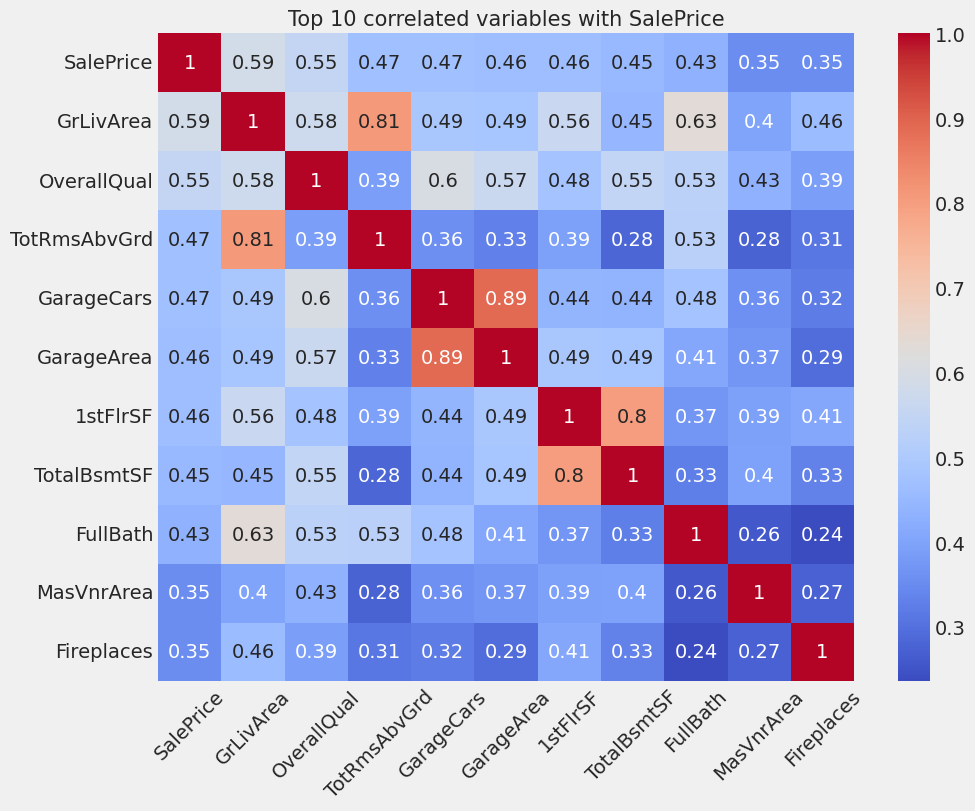

In [ ]:
# Heatmap of top 10
plt.figure(figsize=(10, 8))
top_corr_vars = corrs.head(11).index  # SalePrice + top 10
ax = sns.heatmap(df[top_corr_vars].corr(), annot=True, cmap="coolwarm")

plt.title("Top 10 correlated variables with SalePrice", fontsize=15)
ax.tick_params(axis='x',rotation=45)
plt.show()


Saved: SalePrice_by_Overall_Quality.png


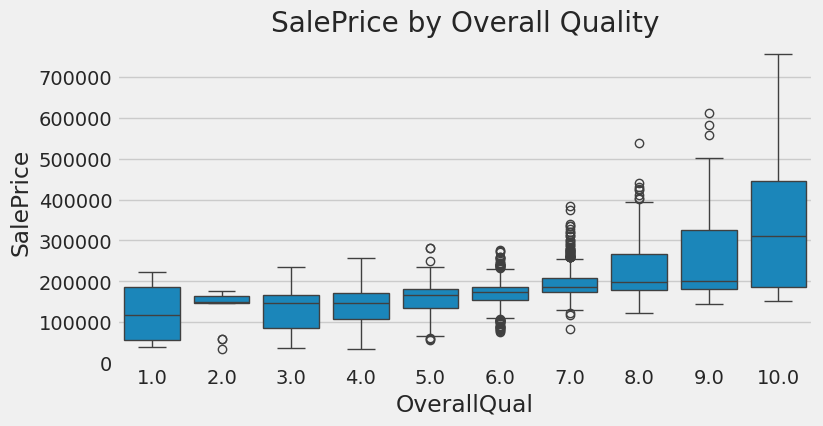

In [ ]:
# Boxplot: OverallQual vs SalePrice
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["OverallQual"], y=df["SalePrice"])
plt.title("SalePrice by Overall Quality")
plt.show()

Saved: GrLivArea_vs_SalePrice_with_Regression_Line.png


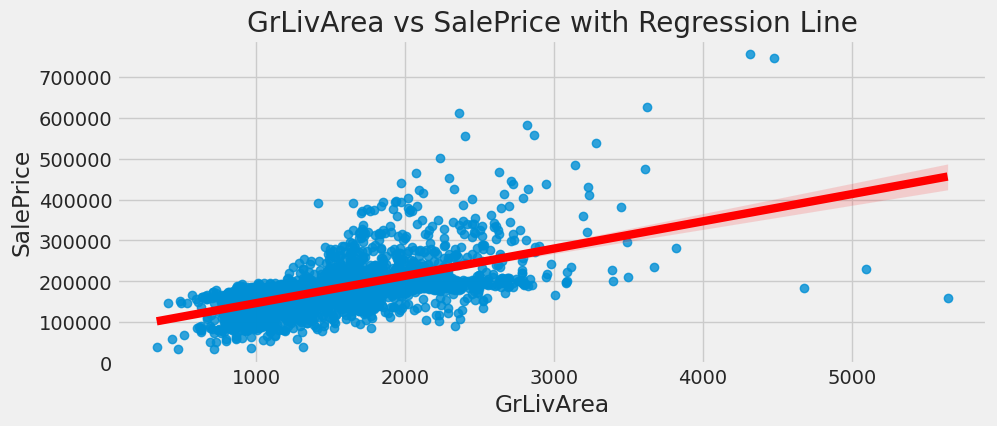

In [ ]:
# Scatter: GrLivArea vs SalePrice
plt.figure(figsize=(10, 4))
sns.regplot(x=df["GrLivArea"], y=df["SalePrice"], line_kws={"color":"red"})
plt.title("GrLivArea vs SalePrice with Regression Line")
plt.show()

####Important Categorical Predictors

Saved: Number_of_Sales_by_Year_Sold.png


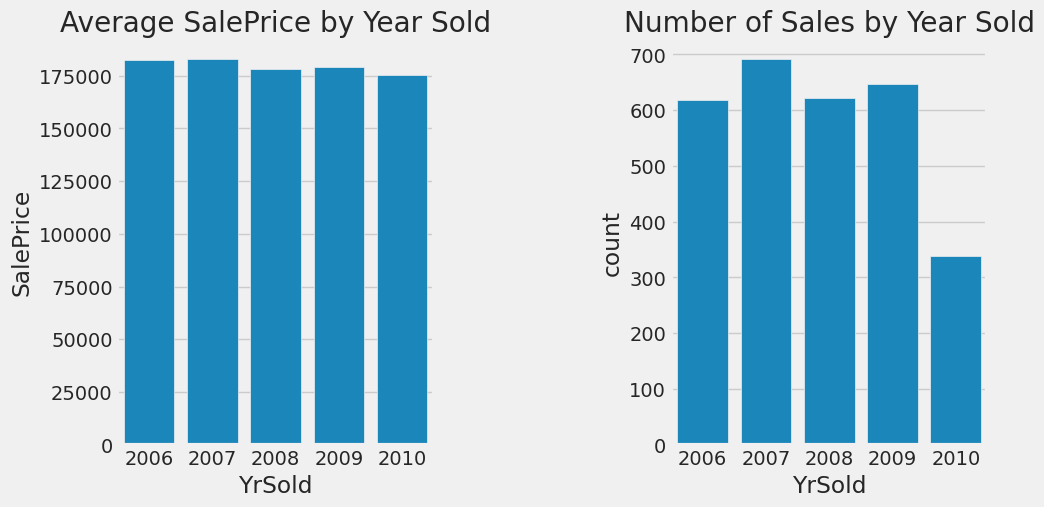

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.barplot(x="YrSold", y="SalePrice", data=df_raw, errorbar=None, ax=axes[0])
axes[0].set_title("Average SalePrice by Year Sold")

sns.countplot(x="YrSold", data=df_raw, ax=axes[1])
axes[1].set_title("Number of Sales by Year Sold")

plt.subplots_adjust(wspace=0.75)
plt.show()


Saved: Number_of_Sales_by_Month_Sold.png


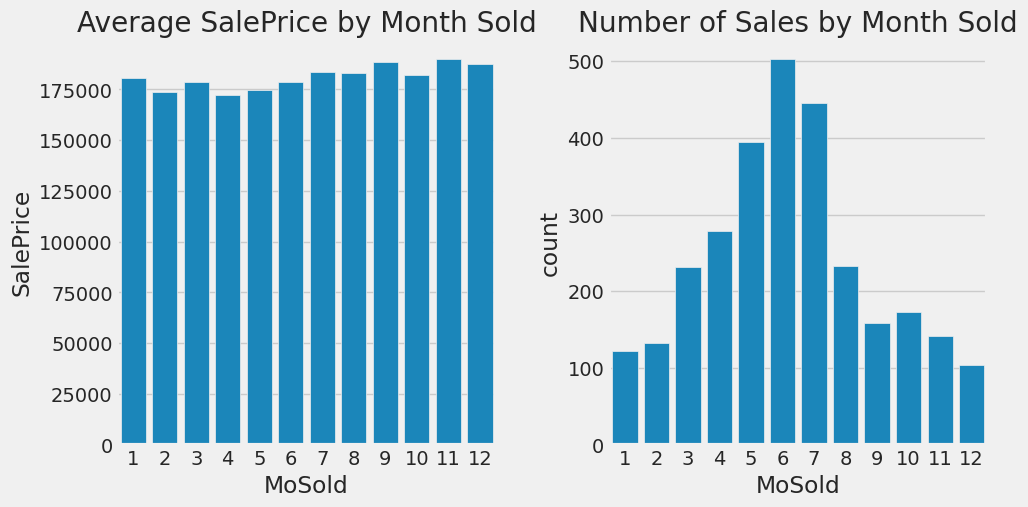

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x="MoSold", y="SalePrice", data=df_raw, errorbar=None, ax=axes[0])
axes[0].set_title("Average SalePrice by Month Sold")

sns.countplot(x="MoSold", data=df_raw, ax=axes[1])
axes[1].set_title("Number of Sales by Month Sold")

# Add space between plots
plt.subplots_adjust(wspace=0.3)

plt.show()

/tmp/ipython-input-1373819.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Neighborhood", y="SalePrice", data=df_raw,


Saved: Median_SalePrice_by_Neighborhood_(sorted).png


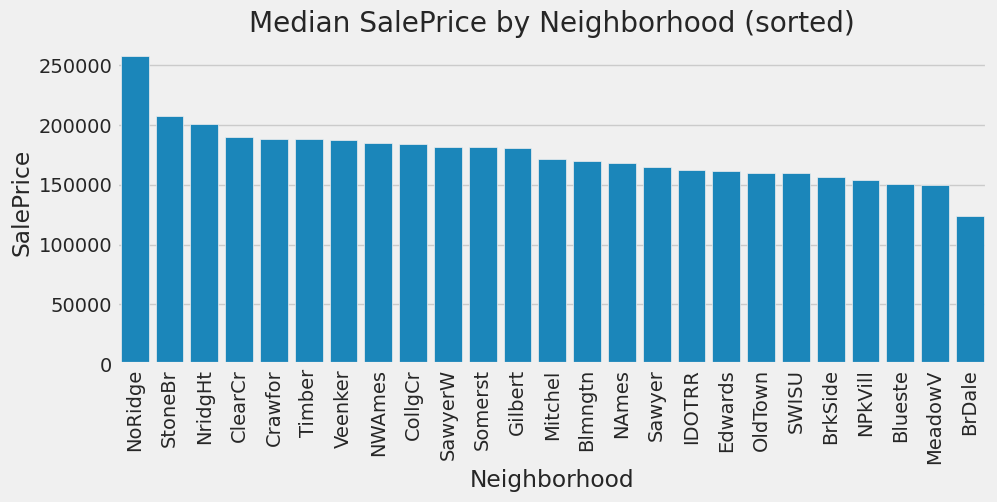

In [ ]:
# Compute median SalePrice per Neighborhood
order = df_raw.groupby("Neighborhood")["SalePrice"].median().sort_values(ascending=False).index
# Plot with sorted order
plt.figure(figsize=(10, 4))
sns.barplot(x="Neighborhood", y="SalePrice", data=df_raw,
            estimator=np.median, ci=None, order=order)
plt.xticks(rotation=90)
plt.title("Median SalePrice by Neighborhood (sorted)")
plt.show()


/tmp/ipython-input-1519399214.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="MSSubClass", y="SalePrice", data=df_raw,


Saved: Median_SalePrice_by_MSSubClass_(sorted).png


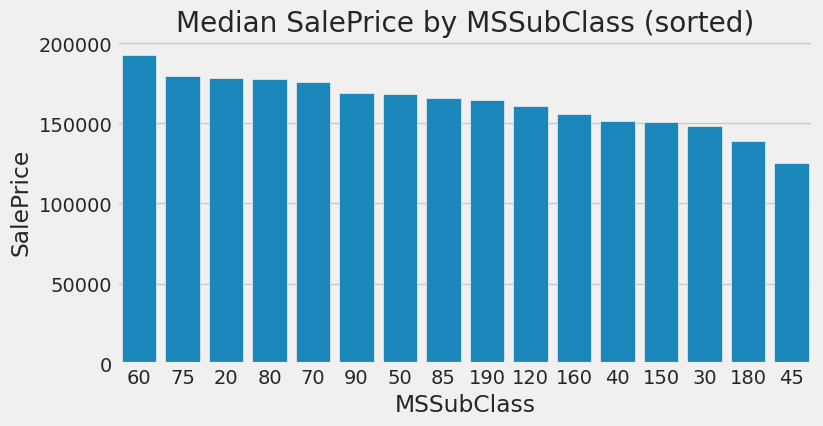

In [ ]:
# Compute median SalePrice per MSSubClass and sort
order = df_raw.groupby("MSSubClass")["SalePrice"].median().sort_values(ascending=False).index
# Plot with sorted order
plt.figure(figsize=(8, 4))
sns.barplot(x="MSSubClass", y="SalePrice", data=df_raw,
            estimator=np.median, ci=None, order=order)
plt.title("Median SalePrice by MSSubClass (sorted)")
plt.show()


##3.	Regression Analysis

###3.1	Model Selection

In [ ]:
# Model 0: Top 10 predictors
y = df["SalePrice"]
top10 = corrs.index[1:11]  # exclude SalePrice
X_top10 = df[top10]

# Add constant
X_top10_const = sm.add_constant(X_top10)

# Fit OLS
model_top10 = sm.OLS(y, X_top10_const).fit()
print("Top 10 predictors regression:")
print(model_top10.summary())

Top 10 predictors regression:
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     229.3
Date:                Thu, 02 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:44:17   Log-Likelihood:                -35278.
No. Observations:                2919   AIC:                         7.058e+04
Df Residuals:                    2908   BIC:                         7.064e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.00

In [ ]:
# Log transform check
y_log = np.log(y)
model_log = sm.OLS(y_log, X_top10_const).fit()
print("Top 10 predictors with log(SalePrice):")
print(model_log.summary())

Top 10 predictors with log(SalePrice):
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     235.7
Date:                Thu, 02 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:44:18   Log-Likelihood:                 323.01
No. Observations:                2919   AIC:                            -624.0
Df Residuals:                    2908   BIC:                            -558.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const    

Saved: Correlation_among_Top_10_Predictors.png


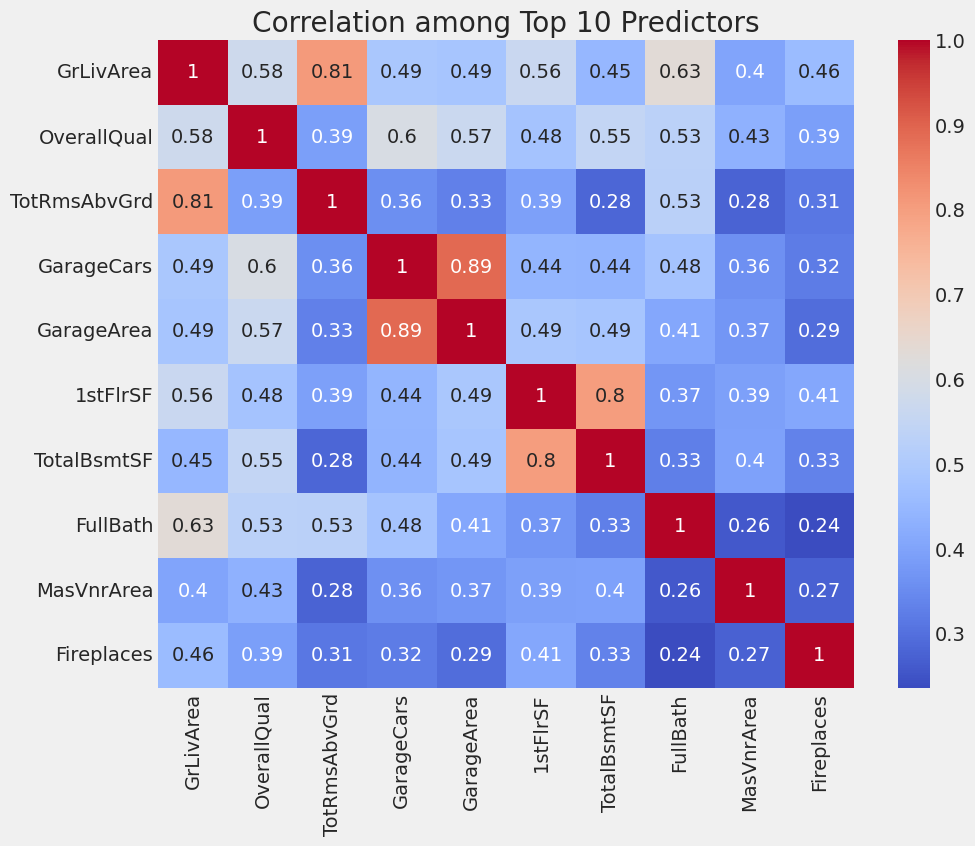

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_top10.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation among Top 10 Predictors")
plt.show()

In [ ]:
# Model 1: drop insignificant predictors from top 10
pvals = model_top10.pvalues
insig = pvals[pvals > 0.05].index
if 'const' in insig:
    insig = insig.drop('const')  # safely remove const if present

X_model1 = X_top10.drop(columns=insig)
X_model1_const = sm.add_constant(X_model1)
model1 = sm.OLS(y, X_model1_const).fit()
print("Model 1 (refined top 10):")
print(model1.summary())

Model 1 (refined top 10):
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     326.9
Date:                Thu, 02 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:44:23   Log-Likelihood:                -35280.
No. Observations:                2919   AIC:                         7.058e+04
Df Residuals:                    2911   BIC:                         7.062e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.028e+0

In [ ]:
# Predictors (drop Id and SalePrice
X_all = df.drop(columns=['Id', 'SalePrice'])
# Ensure all predictors are numeric and keep DataFrame format
X_all = X_all.apply(pd.to_numeric, errors='coerce')
# Add constant term
X_all_const = sm.add_constant(X_all)
# Target variable
y = pd.to_numeric(df['SalePrice'], errors='coerce')

# Drop rows with missing values
mask = X_all_const.notnull().all(axis=1) & y.notnull()
X_all_const = X_all_const.loc[mask]
y = y.loc[mask]
# DEBUG: check dtypes
print("Any object dtypes left?")
print(X_all_const.dtypes[X_all_const.dtypes == 'object'])
print("y dtype:", y.dtype)


# Fit OLS (with DataFrame -> names preserved)
res_all = sm.OLS(y.astype(float), X_all_const.astype(float)).fit()
print(res_all.summary())

Any object dtypes left?
Series([], dtype: object)
y dtype: float64
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     9.388
Date:                Thu, 02 Oct 2025   Prob (F-statistic):          2.26e-287
Time:                        17:44:29   Log-Likelihood:                -34835.
No. Observations:                2919   AIC:                         7.044e+04
Df Residuals:                    2534   BIC:                         7.274e+04
Df Model:                         384                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

In [ ]:
#Model 2 drop insignificant predictors in all predictors
pvals = res_all.pvalues.copy()
significant_cols = pvals[pvals < 0.05].index.tolist()
if 'const' not in significant_cols:
    significant_cols = ['const'] + [c for c in significant_cols if c != 'const']

X_model2 = X_all_const[significant_cols]
model2 = sm.OLS(y.astype(float), X_model2.astype(float)).fit()

print("\n=== MODEL 2: Significant Predictors Only (p < 0.05) ===")
print(model2.summary())


=== MODEL 2: Significant Predictors Only (p < 0.05) ===
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     77.61
Date:                Thu, 02 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:44:30   Log-Likelihood:                -35078.
No. Observations:                2919   AIC:                         7.024e+04
Df Residuals:                    2879   BIC:                         7.047e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [ ]:
comparison = pd.DataFrame({
    'model': ['All predictors', 'Model 2 (p<0.05)'],
    'n_predictors': [X_all_const.shape[1]-1, X_model2.shape[1]-1],
    'R2': [res_all.rsquared, model2.rsquared],
    'Adj_R2': [res_all.rsquared_adj, model2.rsquared_adj],
    'AIC': [res_all.aic, model2.aic],
    'BIC': [res_all.bic, model2.bic]
}).round(3)
print(comparison)

              model  n_predictors     R2  Adj_R2        AIC        BIC
0    All predictors           387  0.587   0.525  70439.641  72741.554
1  Model 2 (p<0.05)            39  0.513   0.506  70235.154  70474.314


/tmp/ipython-input-418430000.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()],


Saved: Model_1:_Predicted_vs_Actual_(Test_Sample).png


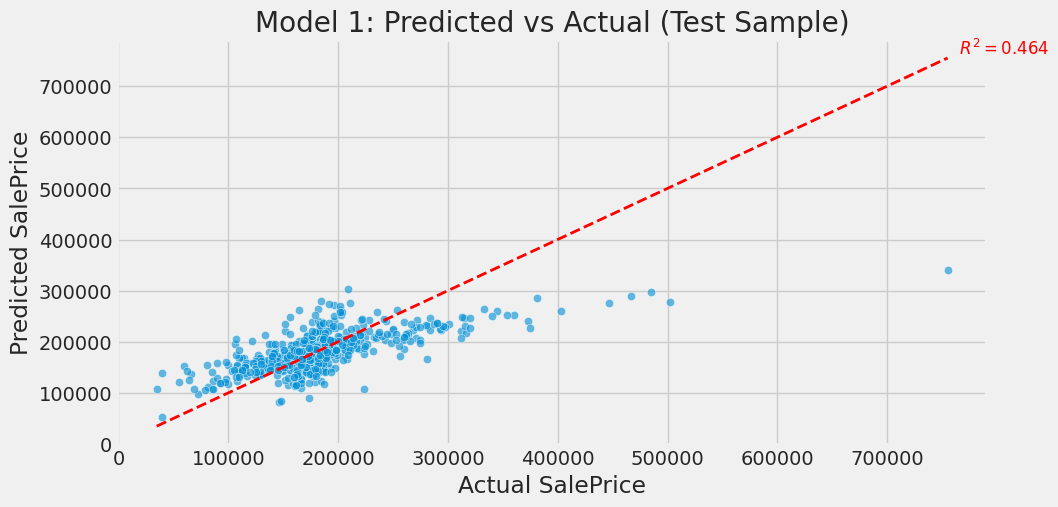

In [ ]:
# Model 1
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_model1, y, test_size=0.2, random_state=42)

# Add constant
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit model
model1_train = sm.OLS(y_train, X_train_const).fit()

# Predictions
y_pred = model1_train.predict(X_test_const)

# Compute R²
r2 = r2_score(y_test, y_pred)

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(10,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# 45-degree line
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2, color="red")

plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Model 1: Predicted vs Actual (Test Sample)")

# --- Place R² label at the end of the 45° line ---
x_end = y_test.max()
y_end = y_test.max()
plt.text(x_end, y_end, f"  $R^2 = {r2:.3f}$",
         fontsize=12, color="red", weight="bold",
         ha="left", va="bottom")

plt.show()


/tmp/ipython-input-3795306347.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y2_test.min(), y2_test.max()],


Saved: Model_2:_Predicted_vs_Actual_(Test_Sample).png


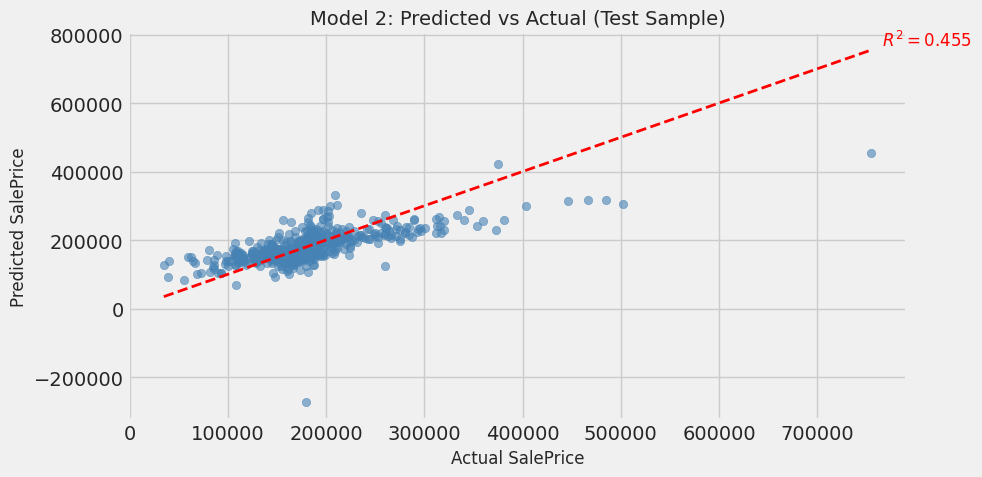

In [ ]:
# Imports
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Train-test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X_model2, y, test_size=0.2, random_state=42)

# Train linear regression
lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)
y2_pred = lr2.predict(X2_test)

# Compute R²
r2_model2 = r2_score(y2_test, y2_pred)

# Plot
plt.figure(figsize=(10,5))
plt.scatter(y2_test, y2_pred, alpha=0.6, color="steelblue")

# 45-degree reference line
plt.plot([y2_test.min(), y2_test.max()],
         [y2_test.min(), y2_test.max()],
         'r--', lw=2, color="red")

# Labels and title
plt.xlabel("Actual SalePrice", fontsize=12)
plt.ylabel("Predicted SalePrice", fontsize=12)
plt.title("Model 2: Predicted vs Actual (Test Sample)", fontsize=14)

# --- Place R² label at the end of the 45° line ---
x_end = y2_test.max()
y_end = y2_test.max()
plt.text(x_end, y_end, f"  $R^2 = {r2_model2:.3f}$",
         fontsize=12, color="red", weight="bold",
         ha="left", va="bottom")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Display RMSE and R² for comparison
rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
r2_1 = r2_score(y_test, y_pred)

# Calculate RMSE and R² for Model 2
rmse2 = np.sqrt(mean_squared_error(y2_test, y2_pred))
r2_2 = r2_score(y2_test, y2_pred)

print("=== Model Comparison ===")
print(f"Model 1 -> RMSE: {rmse1:.2f}, R²: {r2_1:.3f}")
print(f"Model 2 -> RMSE: {rmse2:.2f}, R²: {r2_2:.3f}")

# Interpretation
if r2_2 > r2_1 and rmse2 < rmse1:
    print("\nModel 2 performs better than Model 1: higher R² and lower RMSE.")
elif r2_1 > r2_2 and rmse1 < rmse2:
    print("\nModel 1 performs better than Model 2: higher R² and lower RMSE.")
else:
    print("\nThe models have mixed performance. Compare RMSE and R² to judge which is better.")

=== Model Comparison ===
Model 1 -> RMSE: 44720.68, R²: 0.464
Model 2 -> RMSE: 45057.76, R²: 0.455

Model 1 performs better than Model 2: higher R² and lower RMSE.


/tmp/ipython-input-3017851047.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  mortgage_rates_yearly = mortgage_rates.resample("Y").mean()


Saved: Average_SalePrice_vs_Mortgage_Rates_(2006–2010).png


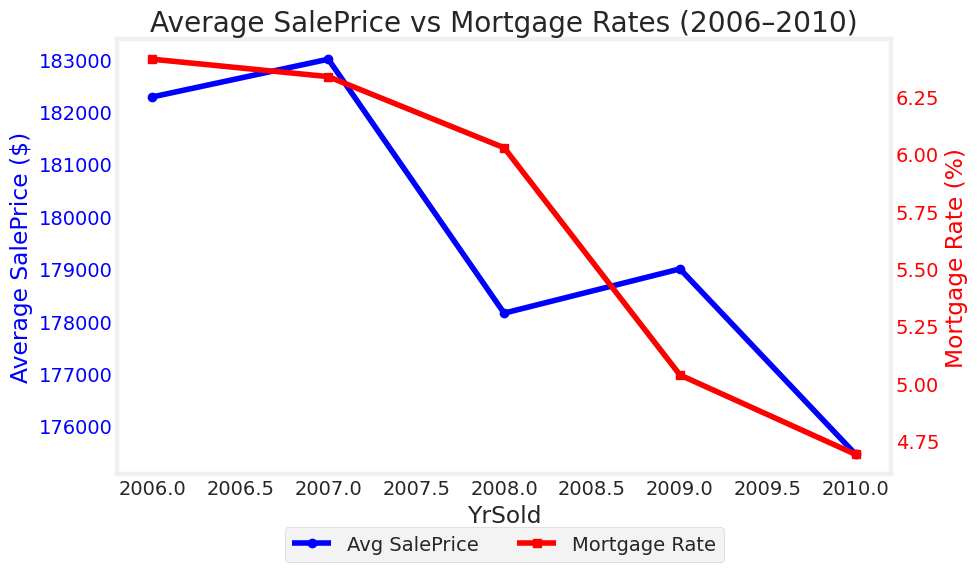

In [ ]:

# --- 1. Mortgage Rates vs Sale Prices ---

start_year, end_year = 2006, 2010

# Get mortgage rates
mortgage_rates = web.DataReader("MORTGAGE30US", "fred", start=f"{start_year}-01-01", end=f"{end_year}-12-31")
mortgage_rates_yearly = mortgage_rates.resample("Y").mean()
mortgage_rates_yearly.index = mortgage_rates_yearly.index.year
mortgage_rates_yearly = mortgage_rates_yearly.rename(columns={"MORTGAGE30US": "MortgageRate"})

# Force index to cover full 2006–2010
mortgage_rates_yearly = mortgage_rates_yearly.reindex(range(start_year, end_year+1))

# Get yearly avg home prices
yearly_prices = df_raw.groupby("YrSold")["SalePrice"].mean()
yearly_prices = yearly_prices.reindex(range(start_year, end_year+1))

# Combine
housing_vs_rates = pd.concat([yearly_prices, mortgage_rates_yearly], axis=1)

# --- Plot: Avg Sale Price vs Mortgage Rate ---
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(housing_vs_rates.index, housing_vs_rates["SalePrice"],
         color="blue", marker="o", label="Avg SalePrice")
ax1.set_xlabel("YrSold")
ax1.set_ylabel("Average SalePrice ($)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(housing_vs_rates.index, housing_vs_rates["MortgageRate"],
         color="red", marker="s", label="Mortgage Rate")
ax2.set_ylabel("Mortgage Rate (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Average SalePrice vs Mortgage Rates (2006–2010)")

# Legends combined
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           loc="upper center", bbox_to_anchor=(0.5,-0.1), ncol=2)

# Clean background
ax1.grid(False)
ax2.grid(False)
ax1.set_facecolor("white")
ax2.set_facecolor("white")
fig.patch.set_facecolor("white")

plt.tight_layout()
plt.show()

/tmp/ipython-input-1509576959.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  delinq_yearly = delinq.resample("Y").mean()


Saved: Sale_Price_vs_Mortgage_Delinquency_Rate_(2006–2010).png


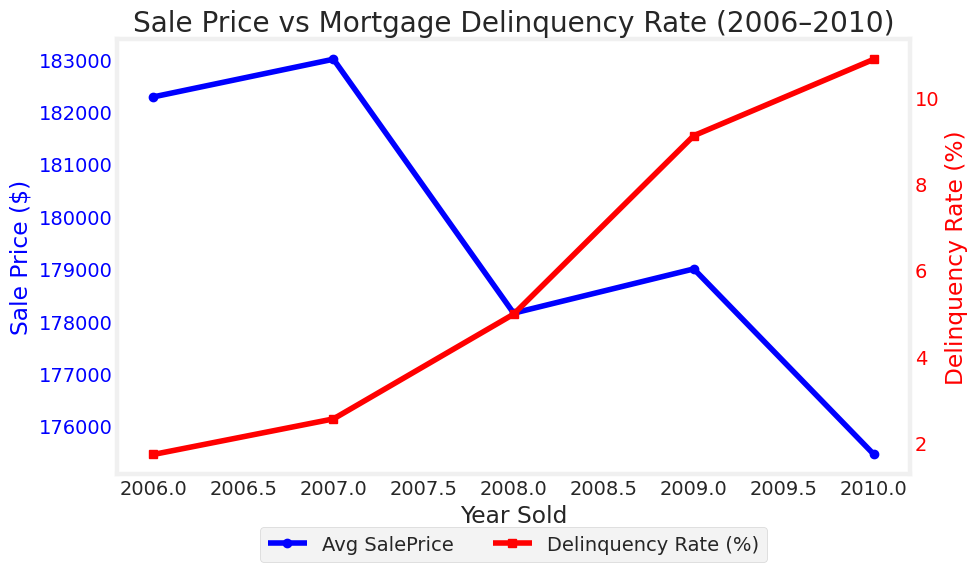

In [ ]:
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import pandas as pd

start_year, end_year = 2006, 2010

# --- Your Sale Price data (from df_raw) ---
yearly_prices = df_raw.groupby("YrSold")["SalePrice"].mean()
yearly_prices = yearly_prices.reindex(range(start_year, end_year+1))

# --- Mortgage Delinquency Rate from FRED ---
series_code = "DRSFRMACBS"  # Delinquency Rate on Single-Family Residential Mortgages, All Commercial Banks
delinq = web.DataReader(series_code, "fred",
                        start=f"{start_year}-01-01", end=f"{end_year}-12-31")

# Convert to yearly average
delinq_yearly = delinq.resample("Y").mean()
delinq_yearly.index = delinq_yearly.index.year
delinq_yearly = delinq_yearly.rename(columns={series_code: "DelinquencyRate"})
delinq_yearly = delinq_yearly.reindex(range(start_year, end_year+1))

# --- Combine ---
housing_vs_delinquency = pd.concat([yearly_prices, delinq_yearly], axis=1)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(10,6))

# Sale Price (left axis)
ax1.plot(housing_vs_delinquency.index, housing_vs_delinquency["SalePrice"],
         color="blue", marker="o", label="Avg SalePrice")
ax1.set_xlabel("Year Sold")
ax1.set_ylabel("Sale Price ($)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Delinquency Rate (right axis)
ax2 = ax1.twinx()
ax2.plot(housing_vs_delinquency.index, housing_vs_delinquency["DelinquencyRate"],
         color="red", marker="s", label="Delinquency Rate (%)")
ax2.set_ylabel("Delinquency Rate (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Sale Price vs Mortgage Delinquency Rate (2006–2010)")

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

# Clean look
ax1.grid(False)
ax2.grid(False)
ax1.set_facecolor("white")
ax2.set_facecolor("white")
fig.patch.set_facecolor("white")

plt.tight_layout()
plt.show()
